In [467]:
import pandas as pd
import numpy as np
import boto3
import json
import os

Outline:
- Translation
- Named Entity Recognition
- LLM call to list key adjectives describing Named Entities
- Total Cost Calculation
- Cost estimation

# Cost Estimation

Retrieve names of services

In [209]:
class PricingFetcher:
    def __init__(self, service_code, region="us-east-1"):
        """
        Initialize the AWS Pricing client and set the service code.
        :param service_code: AWS Service Code (e.g., 'comprehend')
        :param region: AWS region for the Pricing API (default is 'us-east-1')
        """
        self.service_code = service_code
        self.client = boto3.client("pricing", region_name=region)

    def fetch_prices(self, filters):
        """
        Fetch pricing information for the specified service and filters.
        :param filters: List of filter dictionaries for AWS Pricing API
        :return: List of pricing terms in JSON format
        """
        response = self.client.get_products(
            ServiceCode=self.service_code, Filters=filters
        )
        return response["PriceList"]

    def extract_price_function(self, price_list):
        """
        Parse the price list and return a function to calculate the cost based on input units.
        :param price_list: Pricing details fetched from AWS Pricing API
        :return: A cost calculation function
        """
        price_ranges = []

        # Parse through each product in the price list
        for product in price_list:
            terms = json.loads(product).get("terms", {}).get("OnDemand", {})

            for _, term_details in terms.items():
                price_dimensions = term_details.get("priceDimensions", {})

                for _, dimension in price_dimensions.items():
                    begin_range = int(dimension["beginRange"])
                    end_range = (
                        float("inf")
                        if dimension["endRange"] == "Inf"
                        else int(dimension["endRange"])
                    )
                    price_per_unit = float(dimension["pricePerUnit"]["USD"])

                    # Append range and pricing info to a list
                    price_ranges.append((begin_range, end_range, price_per_unit))

        # Sort ranges by beginRange
        price_ranges.sort()

        # Define a pricing function
        def calculate_cost(units, block_size=1000):
            """
            Calculate the cost based on the number of text units.
            :param units: Number of text units
            :return: Total cost in USD
            """
            total_cost = 0.0
            remaining_units = units

            for begin, end, price in price_ranges:
                if remaining_units <= 0:
                    break

                # Determine units to charge in the current range
                units_in_range = min(remaining_units, end - begin)

                block_size = block_size
                total_cost += (units_in_range / block_size) * price

                remaining_units -= units_in_range

            return total_cost

        return calculate_cost


def list_aws_services():
    """
    List all AWS services available in the Pricing API.
    :return: List of service names
    """

    pricing_client = boto3.client("pricing", region_name="us-east-1")
    service_names = []
    next_token = None

    while True:
        # Call describe_services to fetch service details
        if next_token:
            response = pricing_client.describe_services(NextToken=next_token)
        else:
            response = pricing_client.describe_services()

        # Extract service names from the response
        for service in response["Services"]:
            service_names.append(service["ServiceCode"])

        # Check for pagination
        next_token = response.get("NextToken")
        if not next_token:
            break

    return service_names

In [210]:
def compute_service_cost(service_code, filters, units, block_size=1000):
    # Initialize the PricingFetcher class
    fetcher = PricingFetcher(service_code)

    # Fetch pricing details
    price_list = fetcher.fetch_prices(filters)

    # Extract price calculation function
    calculate_cost = fetcher.extract_price_function(price_list)

    cost = calculate_cost(units, block_size=block_size)
    return {"cost": cost, "units": units}

In [211]:
# If you want to list all AWS services available in the Pricing API,
# you can use the following code:
list_aws_services()

['A4B',
 'AWSAmplify',
 'AWSAppFabric',
 'AWSAppRunner',
 'AWSAppStudio',
 'AWSAppSync',
 'AWSApplicationMigrationSvc',
 'AWSB2Bi',
 'AWSBCMPricingCalculator',
 'AWSBackup',
 'AWSBillingConductor',
 'AWSBudgets',
 'AWSCertificateManager',
 'AWSCleanRooms',
 'AWSCloudFormation',
 'AWSCloudMap',
 'AWSCloudTrail',
 'AWSCloudWAN',
 'AWSCodeArtifact',
 'AWSCodeCommit',
 'AWSCodeDeploy',
 'AWSCodePipeline',
 'AWSComputeOptimizer',
 'AWSConfig',
 'AWSCostExplorer',
 'AWSDataExchange',
 'AWSDataSync',
 'AWSDataTransfer',
 'AWSDatabaseMigrationSvc',
 'AWSDeepRacer',
 'AWSDeveloperSupport',
 'AWSDeviceFarm',
 'AWSDirectConnect',
 'AWSDirectoryService',
 'AWSELB',
 'AWSElasticDisasterRecovery',
 'AWSElementalMediaConvert',
 'AWSElementalMediaLive',
 'AWSElementalMediaPackage',
 'AWSElementalMediaStore',
 'AWSElementalMediaTailor',
 'AWSEndUserMessaging3pFees',
 'AWSEnterpriseOnRamp',
 'AWSEntityResolution',
 'AWSEvents',
 'AWSFIS',
 'AWSFMS',
 'AWSGlobalAccelerator',
 'AWSGlueElasticViews',
 'AWS

In [212]:
region = "EU (Ireland)"

llm_service_code = "AmazonBedrock"
input_llm_filters = [
    {"Type": "TERM_MATCH", "Field": "location", "Value": "EU (Ireland)"},
    {"Type": "TERM_MATCH", "Field": "titanModel", "Value": "Titan Text G1 Lite"},
    {"Type": "TERM_MATCH", "Field": "inferenceType", "Value": "Input tokens"},
]
output_llm_filters = [
    {"Type": "TERM_MATCH", "Field": "location", "Value": "EU (Ireland)"},
    {"Type": "TERM_MATCH", "Field": "titanModel", "Value": "Titan Text G1 Lite"},
    {"Type": "TERM_MATCH", "Field": "inferenceType", "Value": "Input tokens"},
]
translate_service_code = "translate"
translate_filters = [
    {"Type": "TERM_MATCH", "Field": "location", "Value": "EU (Ireland)"},
    {"Type": "TERM_MATCH", "Field": "operation", "Value": "TranslateText"},
]
comprehend_service_code = "comprehend"
comprehend_filters = [
    {"Type": "TERM_MATCH", "Field": "location", "Value": "EU (Ireland)"},
    {
        "Type": "TERM_MATCH",
        "Field": "groupDescription",
        "Value": "Processes Entity Analysis text request",
    },
]


In [213]:
compute_service_cost(llm_service_code, output_llm_filters, 10000)

{'cost': 0.0029999999999999996, 'units': 10000}

# Data Preprocessing

The purpose of this article is to demonstrate a feasible data pipeline. Hence, we will greatly limit the number of observations.

In [342]:
df = pd.read_json("data/articles_raw/articles_2024-12-17_19-01-26.json")

In [343]:
df = df[df["article_text"] != ""]
df["article_text_length"] = df["article_text"].apply(lambda x: len(x))

In [344]:
df.drop_duplicates(subset=["article_text"], inplace=True)

In [345]:
df.groupby("source").agg({"article_text": "count"})

,article_text
source,
Magyar Nemzet,115
Telex,92


## Preparing dates

In [ ]:
def parse_dates(date_str):
    # Check if month is in text format
    try:
        return pd.to_datetime(date_str, format="%Y. %B %d. – %H:%M", errors="raise")
    except ValueError:
        return pd.to_datetime(date_str, format="%Y. %m. %d. %H:%M", errors="coerce")


df["publish_date"].str.replace("frissítve", "").str.strip()
# Apply parsing function
df["publish_date"] = df["publish_date"].apply(parse_dates)

In [347]:
# oldest publish date
oldest_telex_article = (
    df.query("source == 'Telex'")
    .query("publish_date == publish_date.min()")["publish_date"]
    .values[0]
)
oldest_telex_article = pd.Timestamp(oldest_telex_article).strftime("%Y-%m-%d")

In [348]:
oldest_mno_article = (
    df.query("source == 'Magyar Nemzet'")
    .query("publish_date == publish_date.min()")["publish_date"]
    .values[0]
)
oldest_mno_article = pd.Timestamp(oldest_mno_article).strftime("%Y-%m-%d")

In [349]:
print(f"The oldest Telex article was published on: {oldest_telex_article}")
print(f"The oldest Magyar Nemzet article was published on: {oldest_mno_article}")

The oldest Telex article was published on: 2024-11-12
The oldest Magyar Nemzet article was published on: 2024-12-06


Filtering for the past week

In [350]:
# filtering for the last 7 days
publish_day_max = df["publish_date"].max()
week_ago = publish_day_max - pd.Timedelta(days=7)
df = df.query("publish_date >= @week_ago")

In [351]:
df.groupby("source").agg({"article_text": "count"})

,article_text
source,
Magyar Nemzet,50
Telex,7


## Filtering

In [352]:
df.query("source == 'Telex'")["article_text_length"]

320    1073
321    2549
324    2052
325    1975
327    2622
328    1420
329    1758
Name: article_text_length, dtype: int64

<Axes: >

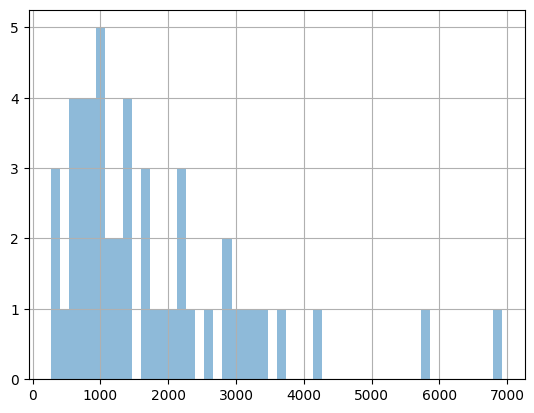

In [ ]:
df.query("source == 'Magyar Nemzet'")["article_text_length"].hist(
    bins=50, alpha=0.5, label="Magyar Nemzet"
)

In [354]:
print("Lenght distribution of articles from Telex:")
print(df.query("source == 'Telex'")["article_text_length"].describe())
print()
print("Lenght distribution of articles from Magyar Nemzet:")
print(df.query("source == 'Magyar Nemzet'")["article_text_length"].describe())

Lenght distribution of articles from Telex:
count       7.000000
mean     1921.285714
std       563.106773
min      1073.000000
25%      1589.000000
50%      1975.000000
75%      2300.500000
max      2622.000000
Name: article_text_length, dtype: float64

Lenght distribution of articles from Magyar Nemzet:
count      50.000000
mean     1744.760000
std      1359.322664
min       273.000000
25%       815.750000
50%      1326.000000
75%      2203.000000
max      6924.000000
Name: article_text_length, dtype: float64


Telex articles are not really skewed, while Magyar Nemzet articles are skewed to the left. 

In [363]:
# selecting 7 articles from Magyar Nemzet
df_magyar_nemzet = (
    df.query("source == 'Magyar Nemzet'")
    .sort_values("article_text_length", ascending=False)
    .head(20)
    .tail(7)
)
print(
    f"The mean length of the selected articles from Magyar nemzet is {df_magyar_nemzet['article_text_length'].mean().round(1)} characters."
)
df_telex = df.query("source == 'Telex'")
print(
    f"The mean length of articles from Telex is {df_telex['article_text_length'].mean().round(1)} characters."
)
df_articles = pd.concat([df_magyar_nemzet, df_telex])

The mean length of the selected articles from Magyar nemzet is 1942.3 characters.
The mean length of articles from Telex is 1921.3 characters.


# Cloud-based Machine Learning pipeline

## Amazon Translate

In [366]:
# Translate the articles to English
# Using boto3 to interact with AWS Translate
translate = boto3.client("translate", region_name="eu-west-1")


def translate_text(text):
    result = translate.translate_text(
        Text=text, SourceLanguageCode="hu", TargetLanguageCode="en"
    )
    return result["TranslatedText"]


df_articles["article_text_en"] = df_articles["article_text"].apply(translate_text)

In [369]:
df_articles[["source", "article_text", "article_text_en"]]

,source,article_text,article_text_en
18,Magyar Nemzet,"Gyalázatos, amit Brüsszel csinál: teljesen tör...",It is shameful what Brussels is doing: they wa...
71,Magyar Nemzet,"„Teljes titokban, a Terrorelhárítási Központ b...","“In complete secrecy, in addition to securing ..."
41,Magyar Nemzet,A Manfred Weber nevű ember világosan – többszö...,The man named Manfred Weber clearly — repeated...
3,Magyar Nemzet,Az idei év legveszélyesebb álhíre volt a Magya...,The most dangerous fake news of this year was ...
102,Magyar Nemzet,Ismét hazudott Magyar Péter\nközösségi oldalán...,Peter Magyar lied again\non the community page...
128,Magyar Nemzet,A Tűzfalcsoport elemzésében azzal vádolta Magy...,"In its analysis, the Firewall Group accused Pé..."
4,Magyar Nemzet,Láng Balázs szokatlan nyíltsággal kommentált e...,Balázs Láng commented with unusual openness on...
320,Telex,"Magyar Péter a Fideszen belülről jött, és a pá...","Péter Magyar came from inside Fidesz, and ther..."
321,Telex,Magyar Péter hétfőn egyebek mellett a kórházi ...,"On Monday, Péter Magyar posted about hospital ..."
324,Telex,„Különösen veszélyes helyzetben van ma a világ...,“The world is in a particularly dangerous situ...


## Amazon recognition

In [410]:
# Extract entities from the articles
comprehend = boto3.client("comprehend", region_name="eu-west-1")

dict_articles = (
    df_articles[["article_text_en", "source"]]
    .reset_index(names="article_id")
    .to_dict(orient="records")
)


def fetch_entities(article):
    result = comprehend.detect_entities(
        Text=article["article_text_en"], LanguageCode="en"
    )
    return {
        "source": article["source"],
        "entities": result["Entities"],
        "article_id": article["article_id"],
        "article_text_en": article["article_text_en"],
    }

In [411]:
recognized_entities = [fetch_entities(article) for article in dict_articles]

In [412]:
recognized_entities

[{'source': 'Magyar Nemzet',
  'entities': [{'Score': 0.9460636377334595,
    'Type': 'ORGANIZATION',
    'Text': 'Brussels',
    'BeginOffset': 20,
    'EndOffset': 28},
   {'Score': 0.9756633639335632,
    'Type': 'OTHER',
    'Text': 'Hungarian',
    'BeginOffset': 59,
    'EndOffset': 68},
   {'Score': 0.8475242257118225,
    'Type': 'DATE',
    'Text': 'Years ago',
    'BeginOffset': 125,
    'EndOffset': 134},
   {'Score': 0.8257966041564941,
    'Type': 'ORGANIZATION',
    'Text': 'Hungary',
    'BeginOffset': 152,
    'EndOffset': 159},
   {'Score': 0.9692625999450684,
    'Type': 'ORGANIZATION',
    'Text': 'Brussels',
    'BeginOffset': 216,
    'EndOffset': 224},
   {'Score': 0.9637095928192139,
    'Type': 'OTHER',
    'Text': 'Hungarian',
    'BeginOffset': 319,
    'EndOffset': 328},
   {'Score': 0.9710349440574646,
    'Type': 'OTHER',
    'Text': 'Hungarian',
    'BeginOffset': 353,
    'EndOffset': 362},
   {'Score': 0.7390232682228088,
    'Type': 'LOCATION',
    'Tex

In [413]:
recognized_entities_df = pd.DataFrame(recognized_entities)

In [414]:
recognized_entities_df

,source,entities,article_id,article_text_en
0,Magyar Nemzet,"[{'Score': 0.9460636377334595, 'Type': 'ORGANI...",18,It is shameful what Brussels is doing: they wa...
1,Magyar Nemzet,"[{'Score': 0.9587474465370178, 'Type': 'ORGANI...",71,"“In complete secrecy, in addition to securing ..."
2,Magyar Nemzet,"[{'Score': 0.9992036819458008, 'Type': 'PERSON...",41,The man named Manfred Weber clearly — repeated...
3,Magyar Nemzet,"[{'Score': 0.9611009955406189, 'Type': 'DATE',...",3,The most dangerous fake news of this year was ...
4,Magyar Nemzet,"[{'Score': 0.999028205871582, 'Type': 'PERSON'...",102,Peter Magyar lied again\non the community page...
5,Magyar Nemzet,"[{'Score': 0.9980241656303406, 'Type': 'ORGANI...",128,"In its analysis, the Firewall Group accused Pé..."
6,Magyar Nemzet,"[{'Score': 0.999187171459198, 'Type': 'PERSON'...",4,Balázs Láng commented with unusual openness on...
7,Telex,"[{'Score': 0.997707724571228, 'Type': 'PERSON'...",320,"Péter Magyar came from inside Fidesz, and ther..."
8,Telex,"[{'Score': 0.9956198334693909, 'Type': 'DATE',...",321,"On Monday, Péter Magyar posted about hospital ..."
9,Telex,"[{'Score': 0.9817485213279724, 'Type': 'DATE',...",324,“The world is in a particularly dangerous situ...


In [438]:
# creating a toplist of entities by source
def toplist_entities(df, top_n=10, top_source="Magyar Nemzet"):
    toplist = (
        df.set_index("source")
        .explode("entities")["entities"]
        .apply(pd.Series)
        .reset_index()
        .groupby(["source", "Text"])
        .size()
        .sort_values(ascending=False)
        .unstack()
        .fillna(0)
        .T.sort_values(top_source, ascending=False)
    )
    return toplist.head(top_n)


toplist_entities(recognized_entities_df, top_n=10, top_source="Magyar Nemzet")


source,Magyar Nemzet,Telex
Text,,
Péter Magyar,24.0,16.0
Hungarian,18.0,4.0
Hungary,8.0,8.0
Tisza Party,8.0,12.0
Brussels,7.0,0.0
Manfred Weber,7.0,0.0
Syrian,7.0,1.0
Hír TV,5.0,0.0
European Commission,4.0,0.0


In [439]:
toplist_entities(recognized_entities_df, top_n=10, top_source="Telex")

source,Magyar Nemzet,Telex
Text,,
Fidesz,4.0,21.0
Péter Magyar,24.0,16.0
Magyar,1.0,16.0
Menczer,0.0,13.0
Tisza Party,8.0,12.0
Hungary,8.0,8.0
Facebook,2.0,7.0
Tamás Menczer,4.0,7.0
Pécs,0.0,6.0


In [452]:
# clean the entities
def clean_entities(entities):
    return [
        {"Text": entity["Text"], "Type": entity["Type"]}
        for entity in entities
        if entity["Score"] > 0.9 and entity["Type"] in ["ORGANIZATION", "PERSON"]
    ]

In [453]:
recognized_entities_df["cleaned_entities"] = recognized_entities_df["entities"].apply(
    clean_entities
)

In [488]:
recognized_entities_df

,source,entities,article_id,article_text_en,cleaned_entities
0,Magyar Nemzet,"[{'Score': 0.9460636377334595, 'Type': 'ORGANI...",18,It is shameful what Brussels is doing: they wa...,"[{'Text': 'Brussels', 'Type': 'ORGANIZATION'},..."
1,Magyar Nemzet,"[{'Score': 0.9587474465370178, 'Type': 'ORGANI...",71,"“In complete secrecy, in addition to securing ...","[{'Text': 'Counter Terrorism Center', 'Type': ..."
2,Magyar Nemzet,"[{'Score': 0.9992036819458008, 'Type': 'PERSON...",41,The man named Manfred Weber clearly — repeated...,"[{'Text': 'Manfred Weber', 'Type': 'PERSON'}, ..."
3,Magyar Nemzet,"[{'Score': 0.9611009955406189, 'Type': 'DATE',...",3,The most dangerous fake news of this year was ...,"[{'Text': 'Daniel Dean', 'Type': 'PERSON'}, {'..."
4,Magyar Nemzet,"[{'Score': 0.999028205871582, 'Type': 'PERSON'...",102,Peter Magyar lied again\non the community page...,"[{'Text': 'Peter Magyar', 'Type': 'PERSON'}, {..."
5,Magyar Nemzet,"[{'Score': 0.9980241656303406, 'Type': 'ORGANI...",128,"In its analysis, the Firewall Group accused Pé...","[{'Text': 'Firewall Group', 'Type': 'ORGANIZAT..."
6,Magyar Nemzet,"[{'Score': 0.999187171459198, 'Type': 'PERSON'...",4,Balázs Láng commented with unusual openness on...,"[{'Text': 'Balázs Láng', 'Type': 'PERSON'}, {'..."
7,Telex,"[{'Score': 0.997707724571228, 'Type': 'PERSON'...",320,"Péter Magyar came from inside Fidesz, and ther...","[{'Text': 'Péter Magyar', 'Type': 'PERSON'}, {..."
8,Telex,"[{'Score': 0.9956198334693909, 'Type': 'DATE',...",321,"On Monday, Péter Magyar posted about hospital ...","[{'Text': 'Péter Magyar', 'Type': 'PERSON'}, {..."
9,Telex,"[{'Score': 0.9817485213279724, 'Type': 'DATE',...",324,“The world is in a particularly dangerous situ...,"[{'Text': 'MTI', 'Type': 'ORGANIZATION'}, {'Te..."


## Amazon Bedrock

In [510]:
def assume_role(role_arn, session_name):
    if os.environ.get("AWS_PROFILE"):
        session = boto3.Session(profile_name=os.environ["AWS_PROFILE"])
    else:
        session = boto3.Session()
    sts_client = session.client("sts")
    assumed_role = sts_client.assume_role(
        RoleArn=role_arn, RoleSessionName=session_name
    )
    return assumed_role["Credentials"]


def send_message_to_bedrock(message):
    role_arn = "arn:aws:iam::870137400553:role/BedrockUserRole"
    credentials = assume_role(role_arn, "BedrockSession")

    session = boto3.Session(
        aws_access_key_id=credentials["AccessKeyId"],
        aws_secret_access_key=credentials["SecretAccessKey"],
        aws_session_token=credentials["SessionToken"],
    )

    bedrock_runtime = session.client(
        service_name="bedrock-runtime",
        region_name="us-east-1",  # Replace with your preferred region
    )

    payload = {
        "inputText": message,
        "textGenerationConfig": {
            "maxTokenCount": 512,
            "stopSequences": [],
            "temperature": 0,
            "topP": 1,
        },
    }

    response = bedrock_runtime.invoke_model(
        modelId="amazon.titan-text-lite-v1",
        contentType="application/json",
        accept="application/json",
        body=json.dumps(payload),
    )

    response_body = json.loads(response["body"].read())
    return response_body["results"][0]["outputText"]

In [526]:
# Creating prompt for each article
# Using boto3 to interact with AWS Bedrock
source = "Telex"
poi = "Magyar Péter"
entities = [
    {"Text": "Magyar Péter", "Type": "PERSON"},
    {"Text": "Menczer Tamás", "Type": "PERSON"},
]
entities_json = json.dumps(entities, ensure_ascii=False)

In [527]:
article_text = recognized_entities_df.query("source == @source")[
    "article_text_en"
].values[0]

In [528]:
# usually it helps to have a prompt that is a bit longer than the actual text
# A summary should come before the important information
# This way, the model can "think loudly" about the arguments
expected_output_format = """{
  "person_of_interest": "<Name of the person> ({poi})",
  "summary": "<A short summary (1-2 sentences) of the article's reflection on the person of interest: {poi}>",
  "source": "<Source of the article>",
  "sentiment": "<favorable / non-favorable / neutral>",
  "keywords": [
    {
      "keyword": "<extracted keyword>",
      "context": "<brief context or sentence around the keyword>"
    },
    {
      "keyword": "<extracted keyword>",
      "context": "<brief context or sentence around the keyword>"
    }
  ],
  "key_entities": [
    {
      "entity": "<name of entity>",
      "type": "<type of entity: person/organization/location>"
    }
  ]
}"""

In [529]:
prompt_template = f"""
### Task Description ###
You are a helpful assistant that analyses news articles related to a Hungarian politican called Magyar Péter.
Some of these articles are from favourable sources, while others are from non-favourable sources.

### Task Details ###
Your task is to extract the keywords related to the person of interest: {poi}. The article may focus on a different subject, but you should only extract the keywords related to the person of interest. 
The article is from the source {source}.
The entities were mined previously with NER techniques. The entities mentioned in the article are:
{entities_json}

### Expected Output ###
The expected output format is a json object with the following structure:
{expected_output_format}

### Article Text ###
{article_text}
"""


In [536]:
print(prompt_template)


### Task Description ###
You are a helpful assistant that analyses news articles related to a Hungarian politican called Magyar Péter.
Some of these articles are from favourable sources, while others are from non-favourable sources.

### Task Details ###
Your task is to extract the keywords related to the person of interest: Magyar Péter. The article may focus on a different subject, but you should only extract the keywords related to the person of interest. 
The article is from the source Telex.
The entities were mined previously with NER techniques. The entities mentioned in the article are:
[{"Text": "Magyar Péter", "Type": "PERSON"}, {"Text": "Menczer Tamás", "Type": "PERSON"}]

### Expected Output ###
The expected output format is a json object with the following structure:
{
  "person_of_interest": "<Name of the person> ({poi})",
  "summary": "<A short summary (1-2 sentences) of the article's reflection on the person of interest: {poi}>",
  "source": "<Source of the article>",
 

In [530]:
# example call
response = send_message_to_bedrock(prompt_template)


In [531]:
print(response)


The keywords related to Magyar Péter are:
- Magyar Péter
- Péter Magyar
- Fidesz
- Lajos Simicska


# Pricing Estimation

## Translation from Hungarian to English

In [367]:
# Amazon Translate costs $15 per million characters.
# The pricing client prices based on 1 character = 1 unit.
number_of_characters = df_articles["article_text"].apply(len).sum()

In [368]:
translation_cost_info = compute_service_cost(
    translate_service_code, translate_filters, number_of_characters, block_size=1
)
print(
    f"Total cost of translation: ${translation_cost_info['cost']:.2f} for {translation_cost_info['units']} characters."
)

Total cost of translation: $0.41 for 27045 characters.


## Named Entity Recognition


In [520]:
# Amazon Comprehend costs $0.0001 per 10M units.
# The pricing client prices based on 100 character = 1 unit.
number_of_characters_en = df_articles["article_text_en"].apply(len).sum()
ner_cost_info = compute_service_cost(
    comprehend_service_code, comprehend_filters, number_of_characters_en, block_size=100
)
print(
    f"Total cost of named entity recognition: ${ner_cost_info['cost']:.2f} for {ner_cost_info['units']} characters."
)

Total cost of named entity recognition: $0.03 for 28511 characters.


## Amazon Bedrock call

## Ex-ante estimation
From templates

In [521]:
# The selected model from Amazon Bedrock costs $0.0000000001 per 1000 units.
# The pricing client prices based on 1000 character = 1 unit.
def tokenizer(text):
    """an average token length is 4 characters"""
    return len(text) / 4


bedrock_input_cost_info = compute_service_cost(
    llm_service_code, input_llm_filters, tokenizer(prompt_template), block_size=1000
)

In [534]:
total_input_cost = bedrock_input_cost_info["cost"] * len(recognized_entities_df)

print(
    f"Total cost of input text generation: ${total_input_cost} for {bedrock_input_cost_info['units']} characters."
)

Total cost of input text generation: $0.0027237 for 648.5 characters.


In [524]:
bedrock_output_cost_info = compute_service_cost(
    llm_service_code,
    output_llm_filters,
    tokenizer(expected_output_format),
    block_size=1000,
)

In [533]:
total_output_cost = bedrock_output_cost_info["cost"] * len(recognized_entities_df)

print(
    f"Total cost of output text generation: ${total_output_cost} for {bedrock_output_cost_info['units']} characters."
)


Total cost of output text generation: $0.0006909 for 164.5 characters.
